[Reference](https://heartbeat.comet.ml/anomaly-detection-using-lstm-autoencoder-b03289895fef)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 35.2MB/s]


In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [4]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


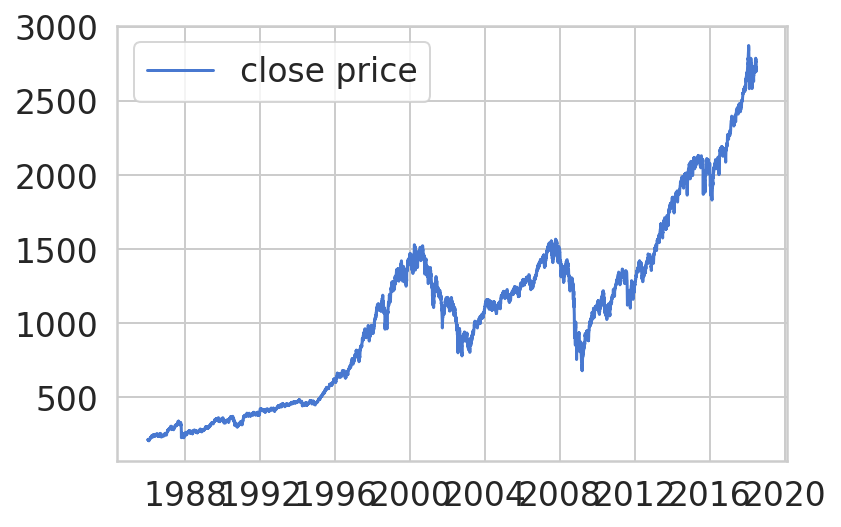

In [5]:
plt.plot(df, label='close price')
plt.legend();

In [6]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [8]:
sequence = 30  
def get_sequences(x, y, sequence=1):    
    x_val = []    
    y_val = []    
 
    for i in range(len(x)-sequence):               
        x_val.append(x.iloc[i:(i+sequence)].values)
        y_val.append(y.iloc[i+sequence]) 
    return np.array(x_val), np.array(y_val) 

X_train, y_train = get_sequences(train[['close']], train['close'], sequence)
X_test, y_test = get_sequences(test[['close']], test['close'], sequence)
print(X_train.shape)

(7752, 30, 1)


In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 19s 62ms/step - loss: 0.1736 - val_loss: 0.2234
Epoch 2/10
218/218 [==============================] - 14s 65ms/step - loss: 0.1018 - val_loss: 0.1828
Epoch 3/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1004 - val_loss: 0.1606
Epoch 4/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1181 - val_loss: 0.2426
Epoch 5/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1260 - val_loss: 0.3078
Epoch 6/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1203 - val_loss: 0.3115
Epoch 7/10
218/218 [==============================] - 7s 32ms/step - loss: 0.1147 - val_loss: 0.1526
Epoch 8/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1057 - val_loss: 0.1754
Epoch 9/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1275 - val_loss: 0.1364
Epoch 10/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1251 - val_

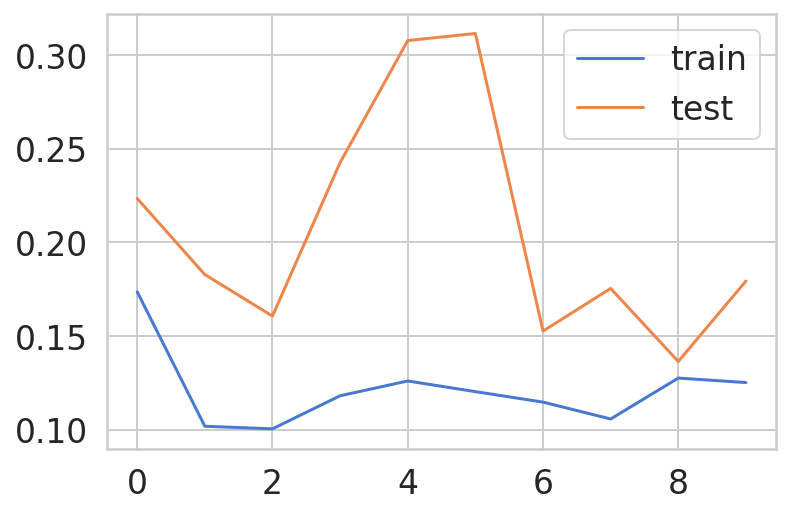

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


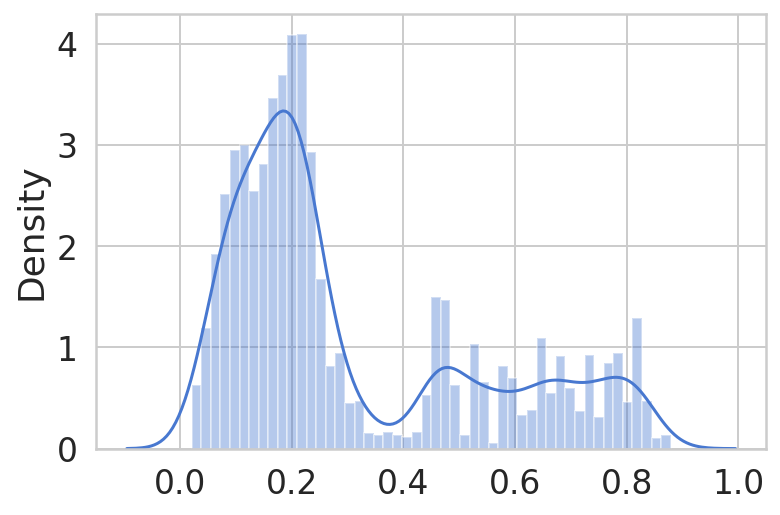

In [13]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [14]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [15]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[sequence:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[sequence:].close

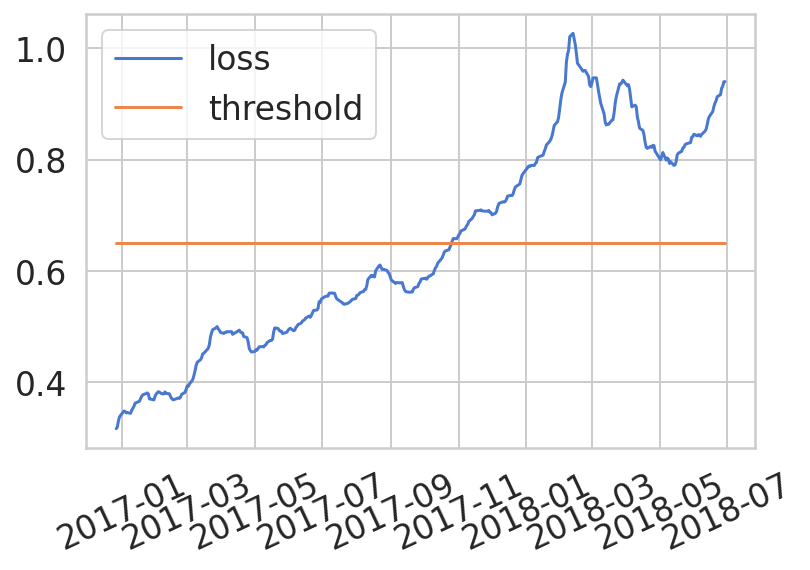

In [16]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [17]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-10-26,0.653635,0.65,True,2.940375
2017-10-27,0.658501,0.65,True,2.979199
2017-10-30,0.657957,0.65,True,2.963722
2017-10-31,0.660698,0.65,True,2.968286
2017-11-01,0.665007,0.65,True,2.975987


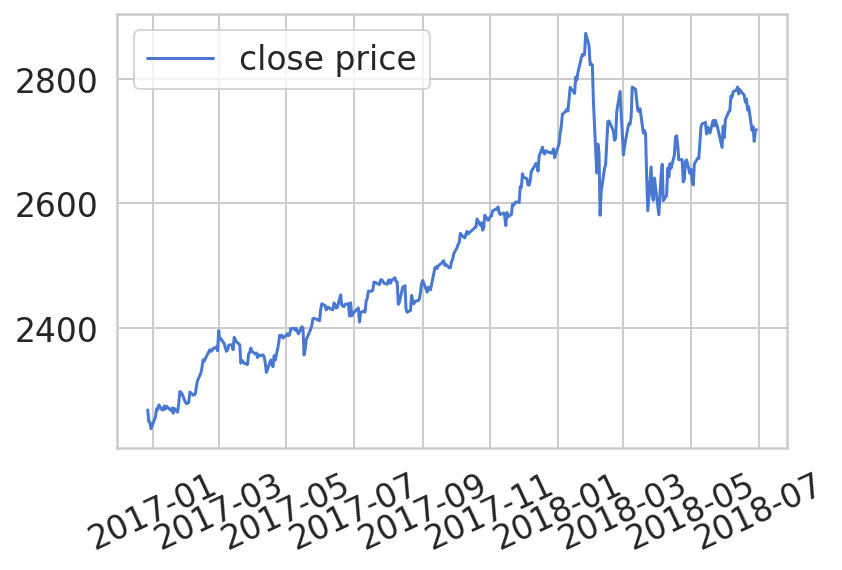

In [18]:
plt.plot(
  test[sequence:].index, 
  scaler.inverse_transform(np.array(test[sequence:].close).reshape(-1, 1)), 
  label='close price'
);

# sns.scatterplot(
#   anomalies.index,
#   scaler.inverse_transform(np.array(anomalies[['close']]).reshape(-1, 1)),
#   color=sns.color_palette()[3],
#   s=52,
#   label='anomaly'
# )
plt.xticks(rotation=25)
plt.legend();